## Importing libraries and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, FunctionTransformer,OneHotEncoder, RobustScaler
from imblearn.over_sampling import  SMOTENC
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearnex import patch_sklearn
patch_sklearn()
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#### We want to unite our colors for plots so we'll use seaborns palette for this

In [2]:
# define sns palette
sns.set_palette('cubehelix')
sns.color_palette('cubehelix')

[(0.10231025194333628, 0.13952898866828906, 0.2560120319409181),
 (0.10594361078604106, 0.3809739011595331, 0.27015111282899046),
 (0.4106130272672762, 0.48044780541672255, 0.1891154277778484),
 (0.7829183382530567, 0.48158303462490826, 0.48672451968362596),
 (0.8046168329276406, 0.6365733569301846, 0.8796578402926125),
 (0.7775608374378459, 0.8840392521212448, 0.9452007992345052)]

## Data Loading, Preprocessing and EDA

#### First we'll need to load our training data and test data(Saved for later)

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#### Let's Check our training dataframe

In [4]:
df_train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


#### We check for information about our data

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


#### We found out that there are object type columns, so we'll need to save them in a list, so we can label encode them, we'll also make a list of numerical columns.

In [6]:
categorical_cols = df_train.select_dtypes(include=['object']).columns
numerical_cols = df_train.select_dtypes(exclude=['object']).columns

#### Using Label encoder we label encode our categorical columns in the whole dataset, I use this step just to measure the importance of each features and their distribution, however I'm willing to use one hot encoding to encode the categorical columns and train the model on it later on.

In [7]:
# merge train and test
df = pd.concat([df_train, df_test])
# Label encoding the categorical variables
df_encoded = df.copy()
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df[col])

#### Retake the train and test data after encoding

In [8]:
df_train_encoded = df_encoded[:len(df_train)]
df_train_encoded

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,1992,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0.0
1,1,15749177,1993,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0.0
2,2,15694510,1217,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0.0
3,3,15741417,1341,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0.0
4,4,15766172,483,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,1758,667,2,0,33.0,2,0.00,1,1.0,1.0,131834.75,0.0
165030,165030,15665521,1986,792,0,1,35.0,3,0.00,1,0.0,0.0,131834.45,0.0
165031,165031,15664752,1211,565,0,1,31.0,5,0.00,1,1.0,1.0,127429.56,0.0
165032,165032,15689614,1215,554,2,0,30.0,7,161533.00,1,0.0,1.0,71173.03,0.0


#### Great! Now we can check our data again and describe it in order to get an overview of things like min, max, mean, std,.. etc

In [9]:
df_train_encoded.describe()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,1599.500188,656.454373,0.648545,0.564429,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,798.932859,80.103340,0.816574,0.495833,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,0.000000,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,958.000000,597.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,1642.000000,659.000000,0.000000,1.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,2260.000000,710.000000,1.000000,1.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,2888.000000,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


#### Check for null values

In [10]:
df_train_encoded.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### All set! Now let's do some feature selection, we'll get the correlation of the features and show them in descending order, then we'll plot them using heatmap, doing this will help us to see which features are important for our model, and we which can we ignore.

In [11]:
corr = df_train_encoded.corr()
corr_descending = corr.sort_values(by='Exited', ascending=False)
corr_descending

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Exited,0.002512,-0.009947,-0.028248,-0.027383,0.053343,-0.146442,0.340768,-0.019565,0.129743,-0.214554,-0.022141,-0.210237,0.018827,1.000000
Age,0.004039,0.002696,-0.020655,-0.008918,0.034110,-0.063139,1.000000,-0.010830,0.064318,-0.102195,-0.012111,0.003320,-0.005399,0.340768
Balance,0.000606,-0.008348,-0.132849,0.006973,0.134642,-0.014699,0.064318,-0.009481,1.000000,-0.361033,-0.018584,-0.015073,0.008586,0.129743
Geography,0.005552,-0.001249,-0.037736,0.005379,1.000000,-0.012092,0.034110,0.000276,0.134642,-0.025123,-0.016715,-0.003493,-0.004102,0.053343
EstimatedSalary,-0.001552,0.002891,0.037849,-0.001820,-0.004102,-0.007778,-0.005399,0.000971,0.008586,-0.004285,0.004438,-0.008080,1.000000,0.018827
id,1.000000,-0.000387,0.000349,-0.001201,0.005552,0.001929,0.004039,-0.002560,0.000606,-0.000094,-0.004706,0.000418,-0.001552,0.002512
CustomerId,-0.000387,1.000000,0.005212,0.007364,-0.001249,-0.001944,0.002696,-0.001252,-0.008348,0.004380,-0.005469,-0.002934,0.002891,-0.009947
Tenure,-0.002560,-0.001252,-0.002198,0.000942,0.000276,0.008767,-0.010830,1.000000,-0.009481,0.007335,0.005327,-0.005532,0.000971,-0.019565
HasCrCard,-0.004706,-0.005469,0.011043,-0.002828,-0.016715,0.006418,-0.012111,0.005327,-0.018584,0.005482,1.000000,-0.021034,0.004438,-0.022141
CreditScore,-0.001201,0.007364,0.008623,1.000000,0.005379,0.002310,-0.008918,0.000942,0.006973,0.011361,-0.002828,0.014790,-0.001820,-0.027383


#### Heatmap helps us to see which features are important for our model with the help of correlation and color.

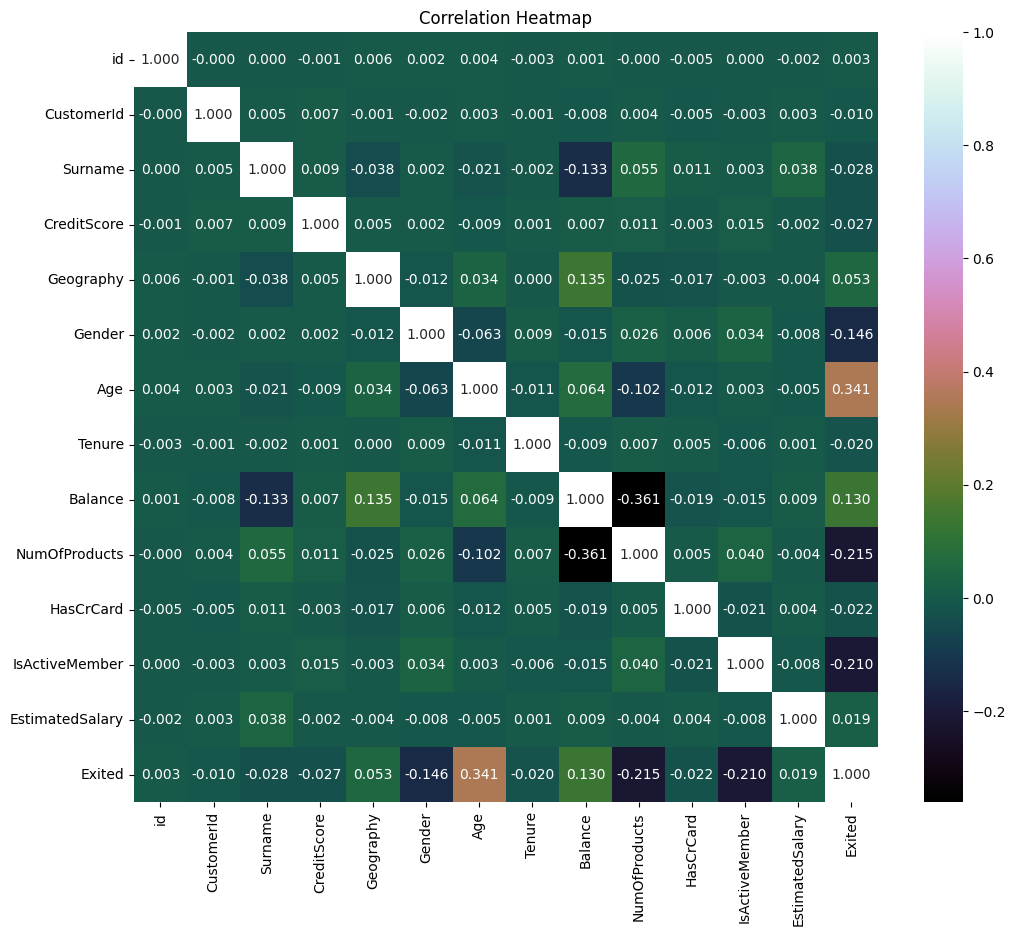

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr,annot=True, fmt='.3f', cmap='cubehelix')
plt.title('Correlation Heatmap')
plt.show()

#### I'm willing to ignore features with correlation between -0.01 and 0.01

In [13]:
selected_features = corr['Exited'][(corr['Exited'] > 0.01) | (corr['Exited'] < -0.01)].index
df_train_filtered = df_train_encoded[selected_features]

#### Now let's check the features we selected

In [14]:
df_train_filtered.columns

Index(['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

#### Looks great, let's see the balance of our target variable

<AxesSubplot: ylabel='count'>

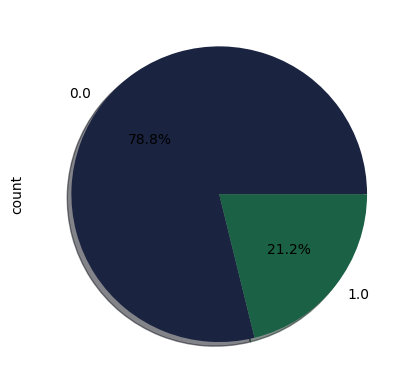

In [15]:
# plot pie chart for exited
df_train_filtered['Exited'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True)

#### Wow, so unbalanced! we'll deal with that later, Let's check the distribution of our features

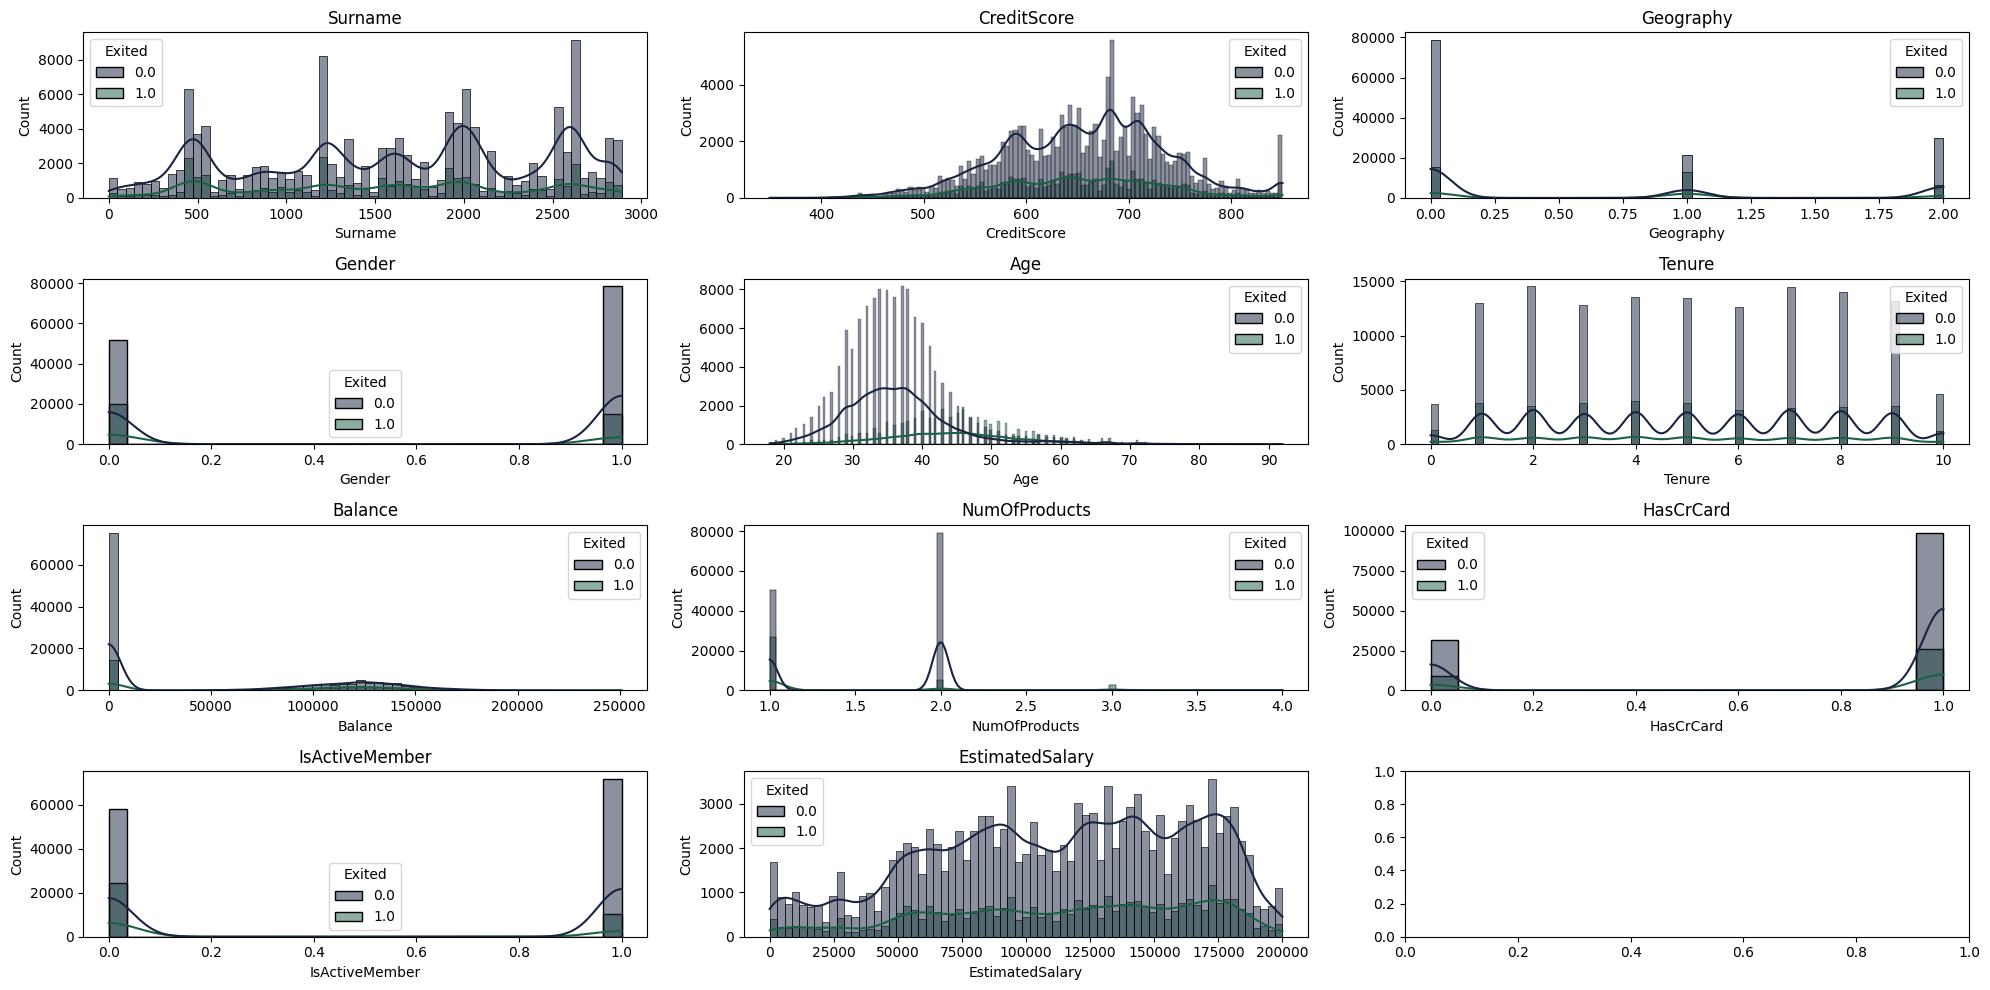

In [16]:
fig, ax = plt.subplots(nrows=(len(df_train_filtered.columns) - 1) // 3 + 1, ncols=3, figsize=(20, 10))

for i, col in enumerate(df_train_filtered.columns):
    if col != 'Exited':
        sns.histplot(x=col, hue='Exited', data=df_train_filtered, ax=ax[i // 3, i % 3], kde=True)
        ax[i // 3, i % 3].set_title(col)

plt.tight_layout()
plt.show()

#### Now for the boxplots we can see the distribution of our features and grasp the outliers along with the 25% and 75% percentiles

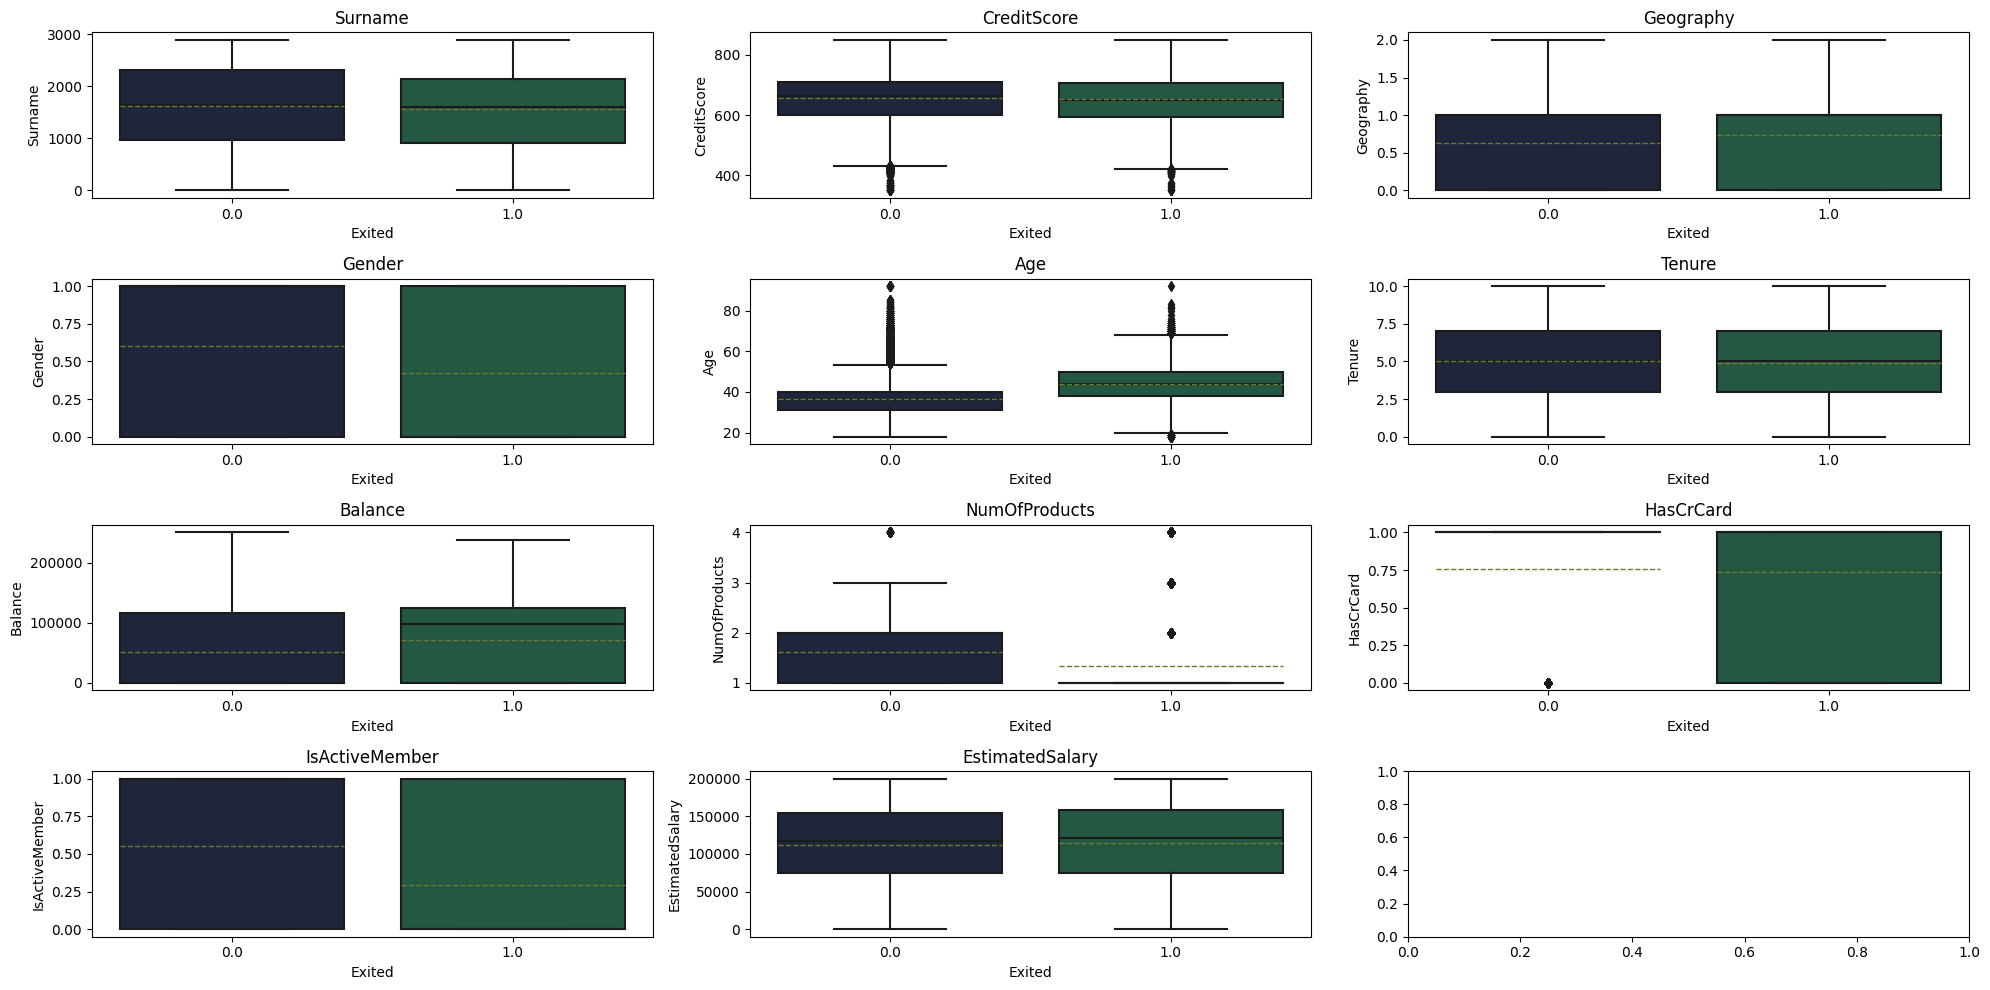

In [17]:
fig , ax = plt.subplots(nrows=(len(df_train_filtered.columns) - 1) // 3 + 1, ncols=3, figsize=(20, 10))

for i, col in enumerate(df_train_filtered.columns):
    if col != 'Exited':
        sns.boxplot(x='Exited', y=col, data=df_train_filtered, ax=ax[i // 3, i % 3], showmeans=True, meanline=True)
        ax[i // 3, i % 3].set_title(col)

plt.tight_layout()
plt.show()

#### Time to specify our X(Features) and y(Target), we'll need to redefine our numerical and categorical columns as well after the feature selection, we'll read our data from the original dataframe

In [18]:
X = df_train[selected_features].drop('Exited', axis=1)
y = df_train['Exited']
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

#### Using SMOTENC To deal with the class imbalance, SMOTENC helps deal with categorical columns as well, unlike SMOTE.

In [19]:
cat_indices = [X.columns.get_loc(col) for col in categorical_cols]
smote = SMOTENC(sampling_strategy='auto', random_state=42, categorical_features=cat_indices)
X, y = smote.fit_resample(X, y)

In [20]:
print('Shape of X',X.shape)
print('Shape of y',y.shape)

Shape of X (260226, 11)
Shape of y (260226,)


#### Let's check the balance of our target again

<AxesSubplot: ylabel='count'>

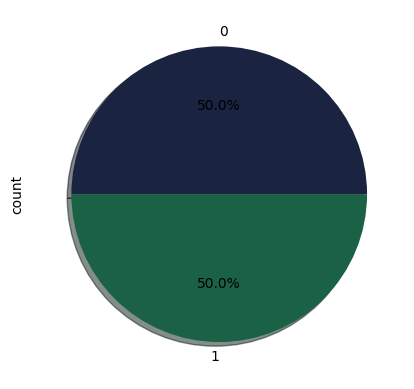

In [21]:
# plot pie chart for exited
y.value_counts().plot.pie(autopct='%1.1f%%', shadow=True)

#### Perfectly balanced, As all things should be.
#### Time for the train test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

## Model

#### Now we get to the model part, I'll make a pipeline doing some feature engineering and then use it to train the model
#### The pipeline Consists of:
#####  1. A Preprocessor that encodes the categorical features using "OneHotEncoder", transforms the features using "Log1p" for skewed features, scales the features using "RobustScaler" for outliers, then applies PolynomialFeatures to the features to capture non-linear relationships between the features 2nd degree, and finally applies PCA to the features which will reduce the dimensionality of the data to 3 components, all helps to get better results.
##### 2. An ensemble of models using StackingClassifier which stacks the models in the order of XGB Classifier,KNN,Bagging Classifier, Random Forest Classifier, Extra Trees Classifier, Ada Boost Classifier, and  all combining their predictions to get better results, with a final estimator of Logistic Regression.

In [25]:
# objects and assignments
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = RobustScaler()
rf = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier()
ada = AdaBoostClassifier (random_state=42)
ext = ExtraTreesClassifier(random_state=42)
xgbC = xgb.XGBClassifier(random_state=42)
bg = BaggingClassifier(random_state=42)
# The preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, categorical_cols),
        ('log_transform', FunctionTransformer(np.log1p), numerical_cols),
        ('scaler', scaler, numerical_cols),
        ('pca', PCA(n_components=3), numerical_cols),
        ('poly', PolynomialFeatures(degree=2), numerical_cols),
    ]
)
# The ensemble model
ensemble = StackingClassifier(
    estimators=[
        ('xgb', xgbC),('knn', knn),('bg',bg),('rf',rf),('ext',ext),('ada',ada)
    ],
)
# The pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ensemble),
])

In [26]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['Surname', 'Geography', 'Gender'], dtype='object')),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dty...
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...)),
                                                ('knn', KNeighborsClassifier()),
                                                ('bg',
                                                 BaggingClassifier(random_state=42)),
                                                ('rf',
                                                 RandomForestClassifier(random_state=42)),
                                                ('ext',
                                                 ExtraTreesClassifier(random_state=42)),
                                                ('ada',
                                                 AdaBoostClassifier(random_state=42))]))])

#### Let's predict our test data

In [27]:
y_pred = model_pipeline.predict(X_test)

#### Let's evaluate our model

In [28]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Confusion matrix
confusion_matrix(y_test, y_pred)
# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9092149252584253
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     26023
           1       0.92      0.89      0.91     26023

    accuracy                           0.91     52046
   macro avg       0.91      0.91      0.91     52046
weighted avg       0.91      0.91      0.91     52046



#### The score is quite good ! Let's plot the roc curve

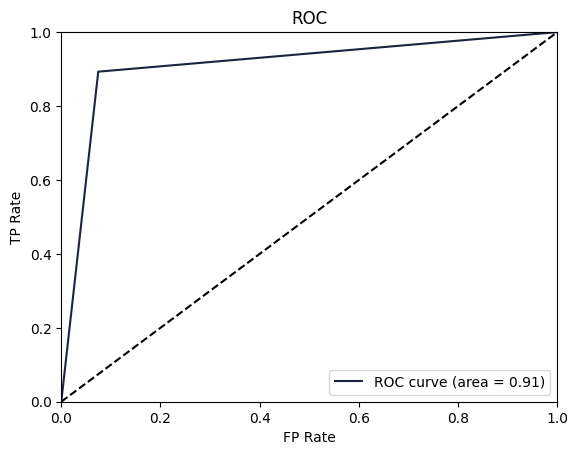

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FP Rate') # False Positive
plt.ylabel('TP Rate') # True Positive
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Submission

#### Now let's use our model to submit the test data provided for the competition

In [30]:
X_sub = df_test
X_sub

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,275053,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,275054,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,275055,15687541,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


#### Let's select the same features as our train data

In [31]:
X_sub = X_sub[X_train.columns]
X_sub

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...
110018,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


#### Let's predict the provided test data probabilities

In [32]:
probabilities = model_pipeline.predict_proba(X_sub)
probabilities

array([[0.98186745, 0.01813255],
       [0.13438906, 0.86561094],
       [0.96935999, 0.03064001],
       ...,
       [0.98882149, 0.01117851],
       [0.9631191 , 0.0368809 ],
       [0.91079268, 0.08920732]])

#### All we need to do now is read the submission dataframe and assign the probabilities to the 'Exited' column of the submission dataframe

In [33]:
sub = pd.read_csv('sample_submission.csv')
sub['Exited'] = probabilities[:, 1]
sub

,id,Exited
0,165034,0.018133
1,165035,0.865611
2,165036,0.030640
3,165037,0.187146
4,165038,0.459301
...,...,...
110018,275052,0.048794
110019,275053,0.127923
110020,275054,0.011179
110021,275055,0.036881


#### Save the submission dataframe to csv file

In [34]:
sub.to_csv('submission.csv', index=False)

## That's it ! Thank you for reading. If you find this notebook useful, please consider UPVoting it.